# Подготовка

## Константы, объявления и неизменные части

In [2]:
import msprime
import tsinfer
import tskit
from Bio import bgzf

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import SVG, display
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE

import builtins
import sys
import os
from shutil import rmtree
import pathlib
import json
import subprocess
import zarr
import concurrent.futures

In [9]:
# константы
# размеры выборок
k_reference = 50
k_learning = 13
k_validation = 3
m = 1 # пока работаем с генерацией одной admixture, чтобы ускорять

ploidy = 2
smp = {"A": k_reference + k_learning, "B": k_reference + k_learning, "C": k_validation}

# пропорция (она неизвестна, её ищем)
# alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
alphas = [0.5]
# параметры демографии
dem_size = 1e4
T_big_split = 1000
T_C = 100 # чтобы успели накопиться изменения

# highly correlated trees - check the correlated changes to optimise trees algorithm
# параметры ARG - chr21
sequence_len=46709983
recomb_rate=1.72443e-08
replicates=24 # надо, чтобы seq_len * num_repl >= 1e9
mut_rate = 1.29e-08

types = ("0", "1", "2", "3", "4")
# методы оптимизации, доступные из scipy
methods = ['COBYLA', 'COBYQA', 'SLSQP', 'trust-constr', 'Nelder-Mead', 'L-BFGS-B', 'Powell', 'TNC']
# целевая переменная находится в этих границах
bnd = ((0.0, 1.0),)
# initial guess is 0.5, because it is random anyway
start_guess = np.array([0.5])

vecsize = k_reference*ploidy+1
long_vecsize = 2*k_reference*ploidy+1

python = sys.executable

## Генерация структур

In [11]:
def build_dem(alpha):
    """
    Строим демографию с нужной admixture
    """
    dem = msprime.Demography()
    dem.add_population(name="A", initial_size=dem_size)
    dem.add_population(name="B", initial_size=dem_size)
    # dem size lower so that faster coalescence lowers the number of trees
    dem.add_population(name="P0", initial_size=dem_size/10) 
    dem.add_population(name="C", initial_size=dem_size/10)
    dem.add_admixture(time=T_C, derived="C", ancestral=["A", "B"], proportions=[alpha, 1-alpha])
    dem.add_population_split(time=T_big_split, derived=["A", "B"], ancestral="P0")
    return dem

In [2]:
# Создаем все множества для манипуляций над ними:
# референсы, обучающие выборки, валидационные выборки
# number of reference/learning/validation могут варьироваться,
# но для упрощения мы делаем порядок следования айдишников
# популяций фиксированным

def natural_arg_sets(ts):
    """
    Делим имеющиеся экземпляры из симулированного арга на выборки
    """
    popA = ts.samples(population_id=0)
    popB = ts.samples(population_id=1)
    refA = popA[:(k_reference*ploidy)]
    refB = popB[:(k_reference*ploidy)]
    reference = np.concat([refA, refB])
    learnA = popA[(k_reference*ploidy) : (k_reference + k_learning)*ploidy]
    learnB = popB[(k_reference*ploidy): (k_reference + k_learning)*ploidy]
    validation_set = ts.samples(population_id=3)
    return reference, learnA, learnB, validation_set

def infered_arg_sets(ts): # only one admixture
    """
    В поле метаданных популяций я вписал айдишники выборок, а не самих популяций
    по ним быстро восстанавливаем референсы, лерн и валидацию
    так как tsinfer не гарантирует сохранение порядка
    """
    # 0 - A-R [0; k_r), 1 - A-L [k_r, k_r + k_l), 2 - B-R [k_r+ k_l, 2*k_r + k_l)
    # 3 - B-L [2*k_r + k_l, 2*k_r + 2*k_l), 4 - C-V [2*k_r + 2*k_l:]
    refA = ts.samples(population_id=0)
    refB = ts.samples(population_id=2)
    reference = np.concat([refA, refB])
    learnA = ts.samples(population_id=1)
    learnB = ts.samples(population_id=3)
    validation_set = ts.samples(population_id=4)
    return reference, learnA, learnB, validation_set

In [10]:
def get_sub_ARG(treeseq, reference, sample):
    """
    Получаем подграф на референсах + наш семпл
    В полученном TS референсами из A будут первые k_r * ploidy индивидуалов
    Фокальный элемент - 2 * k_r * ploidy
    Айдишники семплов поменяются относительно исходного treeseq,
    но относительный порядок нод останется требуемым.
    """
    return treeseq.simplify(np.append(reference, sample))

## Вычисление пропорции по ARG

In [11]:
def target_func(alph, fA, fB, fC):
    """
    calculating the distance between true vector
    and approximating lin comb
    """
    return np.linalg.norm(fC - (alph * fA + (1-alph) * fB))

In [12]:
def single_distribution(treeseq, reference, sample):
    """
    Вектор на подграфе с одной фокальной вершиной
    """
    subts = get_sub_ARG(treeseq, reference, sample)
    newsample = len(subts.samples()) - 1
    vector = np.zeros(vecsize, dtype=np.float64)
    h_single = np.zeros(vecsize, dtype=np.float64)
    g_single = np.zeros(long_vecsize, dtype=np.float64)
    for tree in subts.trees():
        siblings = tree.siblings(newsample)
        nearest = [[leaf for leaf in tree.leaves(sibling)] for sibling in siblings][0]
        if newsample in nearest:
            nearest.remove(newsample)
        nearest = np.array(nearest)
        refA_neighbours = nearest[nearest < ploidy * k_reference].size
        vector[refA_neighbours] += tree.span * nearest.size
        h_single[refA_neighbours] += 1
        g_single[nearest.size] += 1
    vector /= subts.sequence_length
    h_single /= subts.num_trees
    g_single /= subts.num_trees
    return vector, h_single, g_single

In [13]:
def mean_distribution(treeseq, reference, samples):
    """
    Вектор, усредненный по выборке
    """
    vector = np.zeros(vecsize, dtype=np.float64)
    h_mean = np.zeros(vecsize, dtype=np.float64)
    g_mean = np.zeros(long_vecsize, dtype=np.float64)
    for el in samples:
        sss = single_distribution(treeseq, reference, el)
        vector += sss[0]
        h_mean += sss[1]
        g_mean += sss[2]
    vector /= len(samples)
    h_mean /= len(samples)
    g_mean /= len(samples)
    return vector, h_mean, g_mean

In [3]:
def get_vectors(arg, arg_sets_func):
    """
    Получаем векторы распределений + доп информацию для возможных исследований отдельно
    """
    reference, learnA, learnB, validation_set = arg_sets_func(arg)
    ret_table = np.zeros((3, vecsize), dtype=np.float64)
    h_table = np.zeros((3, vecsize), dtype=np.float64)
    g_table = np.zeros((3, long_vecsize), dtype=np.float64)
    mA = mean_distribution(arg, reference, learnA)
    mB = mean_distribution(arg, reference, learnB)
    mC = mean_distribution(arg, reference, validation_set)
    ret_table[0] = mA[0]
    ret_table[1] = mB[0]
    ret_table[2] = mC[0]
    h_table[0] = mA[1]
    h_table[1] = mB[1]
    h_table[2] = mC[1]
    g_table[0] = mA[2]
    g_table[1] = mB[2]
    g_table[2] = mC[2]
    return ret_table, h_table, g_table

In [4]:
def get_arg_stats(ARG):
    """
    Доп информация об арге, тоже для статистик
    """
    ans = np.zeros(7, dtype=np.float64)
    span_array = [tree.span for tree in ARG.trees()]
    ans[0] = np.mean(span_array)
    ans[1] = np.var(span_array)
    ans[2] = np.median(span_array)
    ans[3] = ARG.num_trees
    ans[4] = ARG.num_edges
    ans[5] = ARG.num_nodes
    ans[6] = ARG.nbytes
    return ans

## Визуализация полученного

In [9]:
def visualize_one_alpha(results, a_results, version, universe):
    """
    Слева показываем значения истинной alpha,
    предсказанной на истинном арге
    и предсказанной на восстановленном арге

    Справа строим график целевой функции, полученной из истинного арга
    и из восстановленного
    """
    fig, axs = plt.subplots(1, 2, width_ratios=[0.7, 2])
    fig.set_size_inches(19, 7)
    alpha_linsp_x = np.linspace(0, 1, 100)
    corr, nat, inff = results[0]
    
    axs[0].set_yticks(np.arange(0, 1.1, 0.05))
    axs[0].axhline(y=corr, color='g', label=f"true={corr:.3f}")
    axs[0].axhline(y=nat, color='b', label=f"simulation={nat :.3f}")
    axs[0].axhline(y=inff, color='r', label=f"infered={inff:.3f}")
    axs[0].legend(loc='upper right', prop={'size': 15})
    insert = f"|T-S|={abs(corr-nat) :.3f}\n|T-I|={abs(corr-inff):.3f}\n|I-S|={abs(inff-nat):.3f}"
    axs[0].text(0.6, 0.6, insert, size=14,
                   bbox=dict(boxstyle="round",
                    ec=(0, 0, 0),
                    fc=(1, 1, 1),))
    
    func_y_nat = np.array([target_func(a,a_results[0][0][0],
                                       a_results[0][0][1],
                                       a_results[0][0][2])
                           for a in alpha_linsp_x])    
    func_y_inf = np.array([target_func(a,a_results[0][1][0], 
                                       a_results[0][1][1],
                                       a_results[0][1][2])
                           for a in alpha_linsp_x])
    axs[1].plot(alpha_linsp_x, func_y_nat, label="sim opt func")
    axs[1].plot(alpha_linsp_x, func_y_inf, label="inf opt func")
    axs[1].set_xticks(np.arange(0, 1.05, 0.05))
    axs[1].legend(loc='upper right', prop={'size': 15})
    
    fig.savefig(f"pictures/chr21_v{version}_u{universe}.png")

In [8]:
def visualize_arg_properties(g_results, h_results, version, universe, status):
    """
    По популяциям строим среднюю долю деревьев относительно числа соседей
    и относительно числа соседей из A
    """
    # alphas x 3 x vecsize
    al, _, _ = g_results.shape
    fig, axs = plt.subplots(3, 2, width_ratios=[1, 1.5])
    fig.set_size_inches(20, 24)    
    vec_linsp_x = np.linspace(0, vecsize + 1, vecsize)
    long_vec_linsp_x = np.linspace(1, long_vecsize + 1, long_vecsize)
    for i, pop_letter in enumerate(["A", "B", "C"]):
        axs[i][0].set_xticks(np.arange(0, vecsize+15, 10))
        axs[i][0].set_yticks(np.arange(0, 1.1, 0.05))
        axs[i][0].set_xlabel(f"Number of A references neighbors on trees with focal nodes from {pop_letter}")
        axs[i][0].set_ylabel("share among all trees")
        axs[i][0].plot(vec_linsp_x, g_results[ai][0])
    
        axs[i][1].set_xticks(np.arange(1, long_vecsize+15, 15))
        axs[i][1].set_yticks(np.arange(0, 1.1, 0.05))
        axs[i][1].set_xlabel(f"Total number of neighbors on trees for {pop_letter}")
        axs[i][1].set_ylabel("share among all trees")
        axs[i][1].plot(long_vec_linsp_x, h_results[ai][2])
    fig.savefig(f"pictures/chr21_arg_{status}_v{version}_u{universe}.png")

# Основная часть

In [7]:
def worker(tup):
    """
    Подпроцесс, принимающий индекс репликации и истинную альфу. Возвращаем:
    - тензор 2 x 3 x vecsize распределений по аргу
    - тензор 2 x 3 x vecsize долей деревьев с i соседями из refA
    - тензор 2 x 3 x long_vecsize долей деревьев с i соседями
    - массив 2 x 7 со статистиками по истинному аргу и инференсному аргу

    тензоры четырехмерные: по одной трехмерной коробке на истинный арг и восстановленный арг
    """
    debug = False
    alpha, idx, ui = tup
    f_tensor = np.zeros((2, 3, vecsize), dtype=np.float64)
    g_tensor = np.zeros((2, 3, vecsize), dtype=np.float64)
    h_tensor = np.zeros((2, 3, long_vecsize), dtype=np.float64)
    arg_stats_array = np.zeros((2, 7) , dtype=np.float64)
    
    ARG = msprime.sim_ancestry(
        ploidy=ploidy,
        samples=smp,
        demography=build_dem(alpha),
        sequence_length=sequence_len,
        recombination_rate=recomb_rate,
    )
    ARG = msprime.sim_mutations(ARG, rate=mut_rate)
    
    name = f"simulation-v{idx}-u{ui}"
    np.save(f"npy/{name}-AA.npy", [s.ancestral_state for s in ARG.sites()])
    vcf_name = f"vcf/{name}.vcf"
    with bgzf.open(vcf_name, "w") as f:
        ARG.write_vcf(f,
                     position_transform = lambda x: np.fmax(1, np.round(x)) # lambda x: 1 + x
                     ) # allow_position_zero=True
    subprocess.run(["tabix", vcf_name])
    ret = subprocess.run(
        [python, "-m", "bio2zarr", "vcf2zarr", "convert", "--force", vcf_name, f"vcf/{name}.vcz"],
        stderr = subprocess.DEVNULL # if name == "notebook-simulation" else None,
    )
    # метаданные: надо запомнить популяции, а для A/B еще запомнить, референсные ли семплы или обучающие
    # 0 - A-R [0; k_r), 1 - A-L [k_r, k_r + k_l), 2 - B-R [k_r+ k_l, 2*k_r + k_l)
    # 3 - B-L [2*k_r + k_l, 2*k_r + 2*k_l), 4 - C-V [2*k_r + 2*k_l:] 
    
    # догружаем в vcz
    vcf_zarr = zarr.load(f"vcf/{name}.vcz")

    schema = json.dumps(tskit.MetadataSchema.permissive_json().schema).encode()
    zarr.save(f"vcf/{name}.vcz/populations_metadata_schema", schema)
    metadata = [
        json.dumps({"name": pop, "description": "The set this individual belongs to"}).encode()
        for pop in types
    ]
    zarr.save(f"vcf/{name}.vcz/populations_metadata", metadata)
    
    num_individuals = ARG.num_individuals
    # используем поле популяций метаданных для того, чтобы записать группу, но в целом неважно
    individuals_population = np.full(num_individuals, tskit.NULL, dtype=np.int32)
    individuals_population[:k_reference] = 0
    individuals_population[k_reference:k_reference+k_learning] = 1
    individuals_population[k_reference+k_learning:2*k_reference+k_learning ] = 2
    individuals_population[2*k_reference+k_learning:2*k_reference+2*k_learning ] = 3
    individuals_population[2*k_reference+2*k_learning: ] = 4
    zarr.save(f"vcf/{name}.vcz/individuals_population", individuals_population)
    
    # инферим граф:
    ancestral_state = np.load(f"npy/{name}-AA.npy")
    if debug:
        print(f"Debug: trying to open sim{idx}")
    vdata = tsinfer.VariantData(f"vcf/{name}.vcz",
                                ancestral_state,
                                individuals_population="individuals_population")
    if debug:
        print(f"sim{idx} opened. Clear the dir!")
    arg_hat = tsinfer.infer(vdata)    
    # ... и подчищаем за собой
    if not debug:
        os.remove(f"npy/{name}-AA.npy")        
        rmtree(f"vcf/{name}.vcz")
        os.remove(f"vcf/{name}.vcf")
        os.remove(f"vcf/{name}.vcf.tbi")
    
    # заполняем оставшиеся поля
    vectors = get_vectors(ARG, natural_arg_sets)
    vectors_hat = get_vectors(arg_hat, infered_arg_sets)
    f_tensor[0] = vectors[0]
    f_tensor[1] = vectors_hat[0]
    g_tensor[0] = vectors[1]
    g_tensor[1] = vectors_hat[1]
    h_tensor[0] = vectors[2]
    h_tensor[1] = vectors_hat[2]
    arg_stats_array[0] = get_arg_stats(ARG)
    arg_stats_array[1] = get_arg_stats(arg_hat)
    return f_tensor, g_tensor, h_tensor, arg_stats_array

In [236]:
ver = 6

In [237]:
uni = 2

In [220]:
%%time
alpha_results = np.zeros((2, 3, vecsize), dtype=np.float64)
g_results = np.zeros((2, 3, vecsize), dtype=np.float64)
h_results = np.zeros((2, 3, long_vecsize), dtype=np.float64)
arg_stats_results = np.zeros((2, 7), dtype=np.float64)

# for ai, alpha in enumerate(alphas):
inpt = [(alphas[0], ai, uni) for ai in range(replicates)]
with concurrent.futures.ProcessPoolExecutor(max_workers=os.cpu_count()) as executor: # min(os.cpu_count(), replicates)
    many_tuples = list(executor.map(worker, inpt))
    alpha_results = np.mean(np.array([tup[0] for tup in many_tuples]), axis=0)
    g_results = np.mean(np.array([tup[1] for tup in many_tuples]), axis=0)
    h_results = np.mean(np.array([tup[2] for tup in many_tuples]), axis=0)
    arg_stats_results = np.mean(np.array([tup[3] for tup in many_tuples]), axis=0)

np.save(f"u{uni}_v{ver}_alpha_res.npy", alpha_results)
np.save(f"u{uni}_v{ver}_g_res.npy", g_results)
np.save(f"u{uni}_v{ver}_h_res.npy", h_results)
np.save(f"u{uni}_v{ver}_arg_stats.npy", arg_stats_results)

estimation_results = np.zeros(3, dtype=np.float64)
fnA = alpha_results[0][0]
fnB = alpha_results[0][1]
fnC = alpha_results[0][2]
fiA = alpha_results[1][0]
fiB = alpha_results[1][1]
fiC = alpha_results[1][2]
estimation_results[0] = alpha
estimation_results[1] = minimize(target_func, x0=start_guess, args=(fnA, fnB, fnC), method='COBYQA', bounds=bnd).x[0]
estimation_results[2] = minimize(target_func, x0=start_guess, args=(fiA, fiB, fiC), method='COBYQA', bounds=bnd).x[0]

CPU times: user 277 ms, sys: 218 ms, total: 496 ms
Wall time: 51min 23s


In [226]:
print("E span | Var span | M span | E trees | E edges | E nodes of true ARG \n",*[ f"{res :.3f}" for res in  arg_stats_results[0, :] ] )

E span | Var span | M span | E trees | E edges | E nodes of true ARG 
 609.418 371731.906 421.625 76650.667 301618.958 40306.958 18244512.125


In [228]:
print("E span | Var span | M span | E trees | E edges | E nodes of infered ARG \n", *[ f"{res :.3f}" for res in  arg_stats_results[1, :] ])

E span | Var span | M span | E trees | E edges | E nodes of infered ARG 
 1816.411 3681586.238 1200.375 25740.375 156550.208 35146.792 15367422.125


В среднем количество деревьев восстановленного графа уменьшается в 3 раза, соответственно увеличивается их размер. Размах при этом сохраняется.

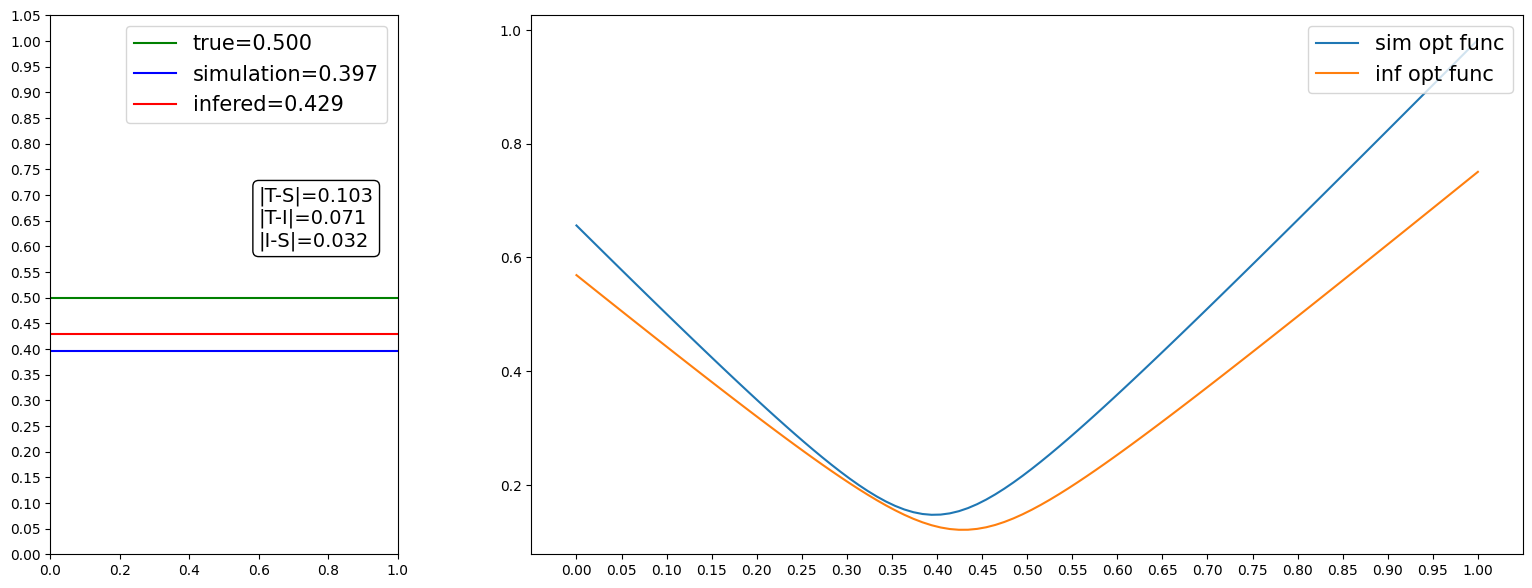

In [211]:
visualize_one_alpha(estimation_results, alpha_results, ver)

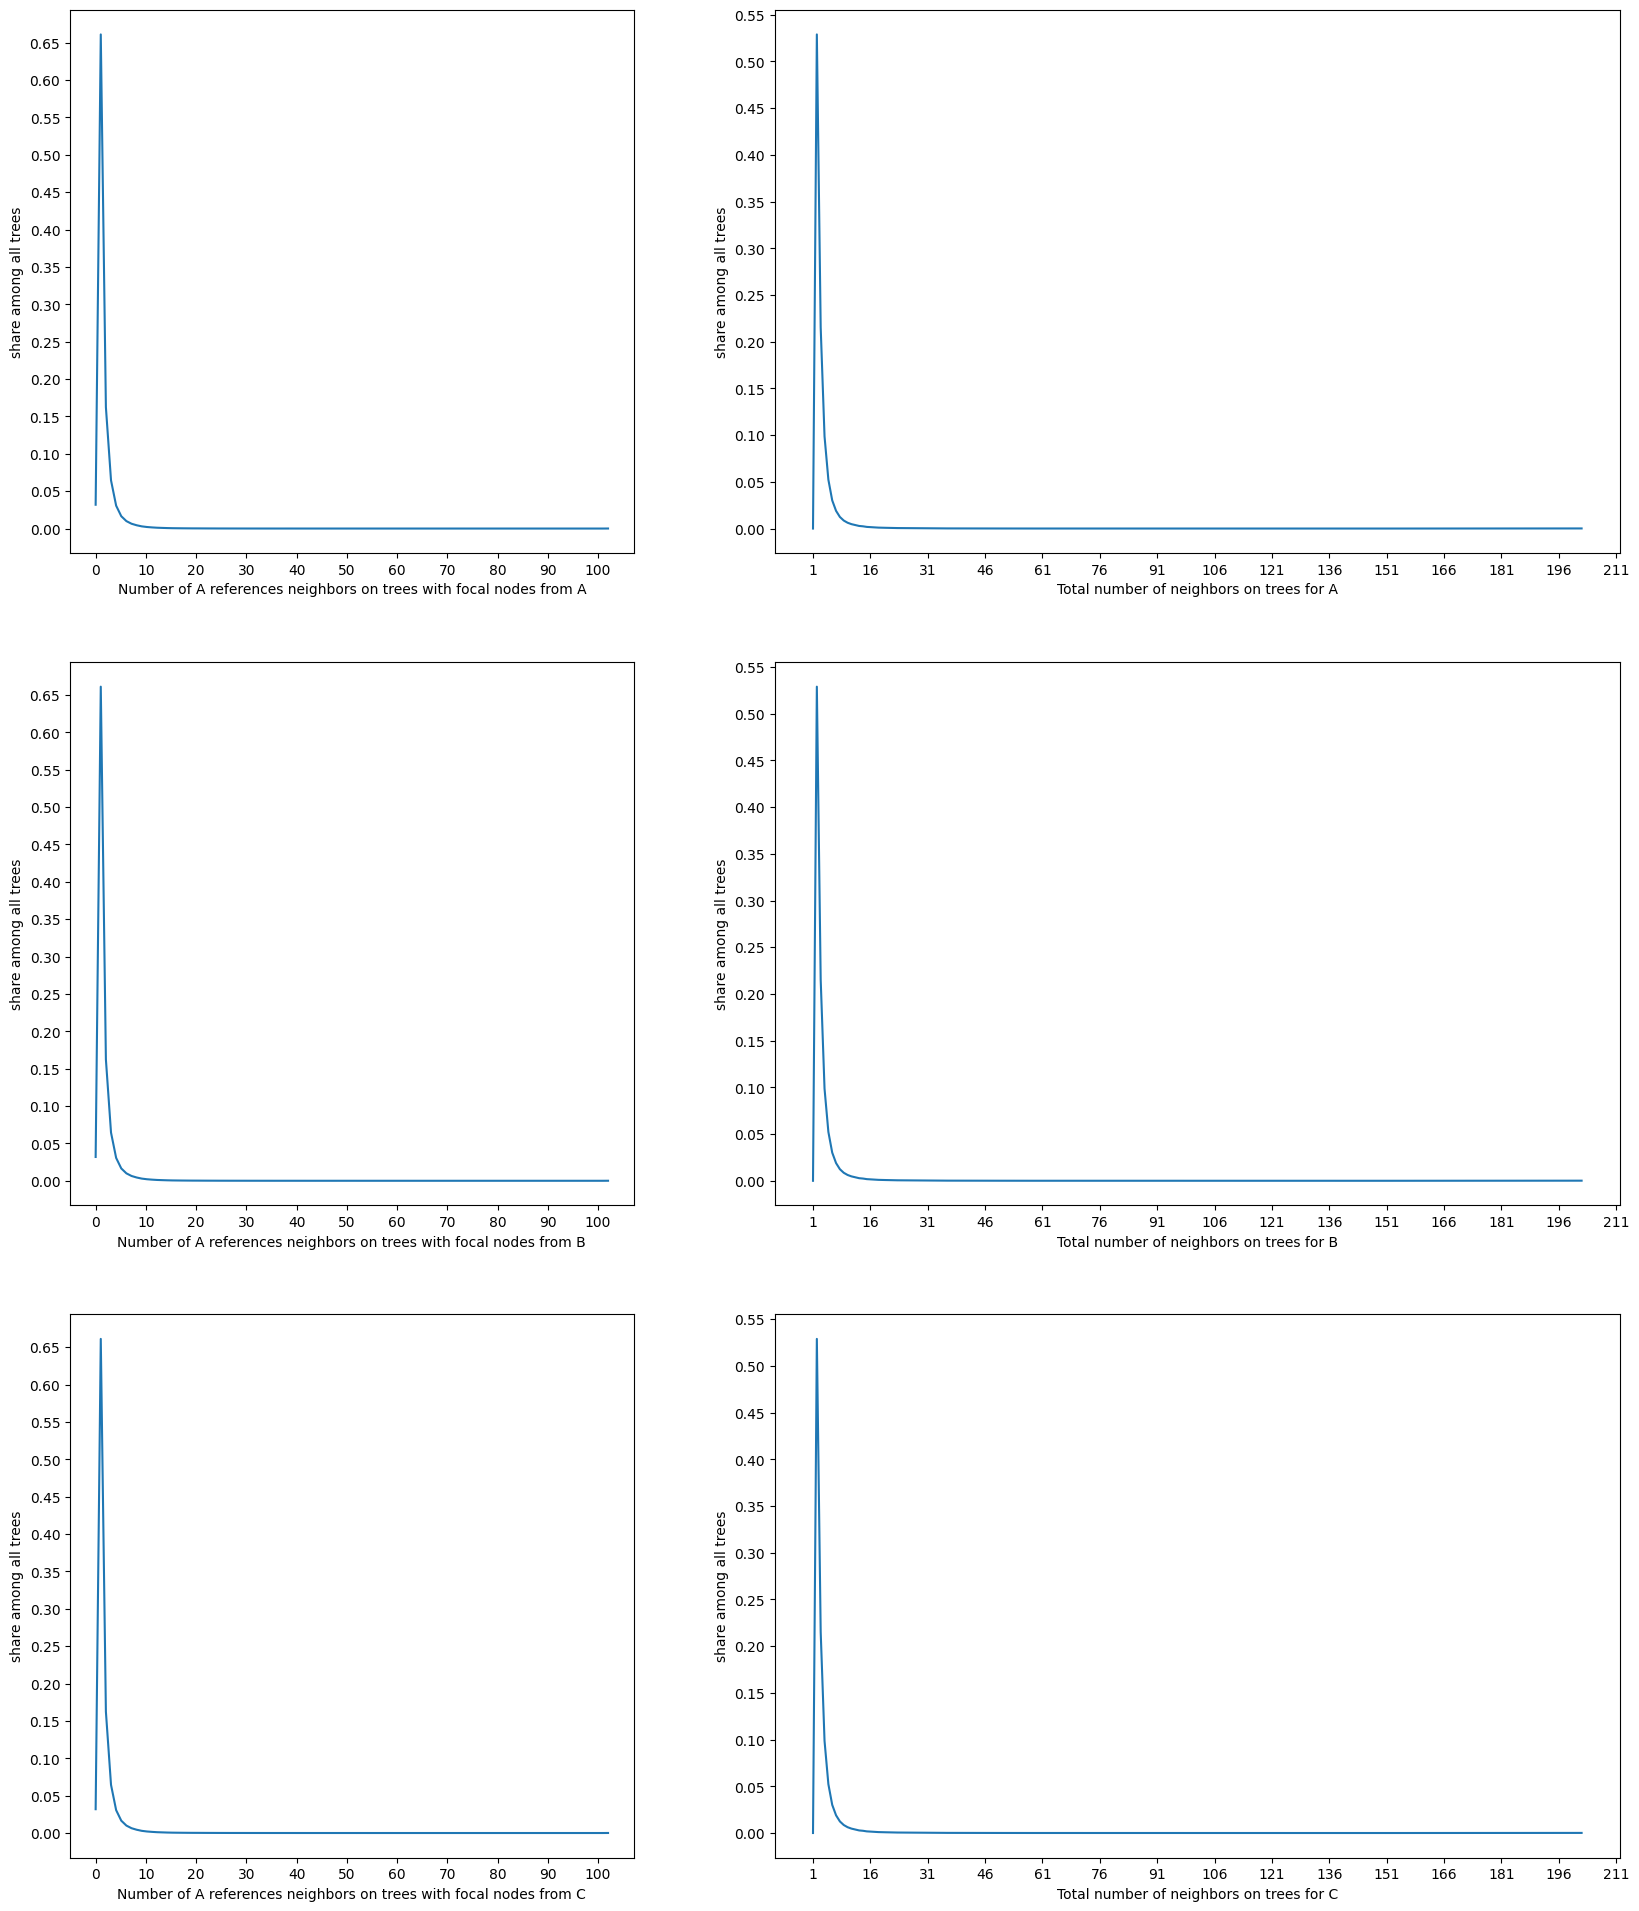

In [206]:
visualize_arg_properties(g_results[:, 0, :, :], h_results[:, 0, :, :], ver, status="true")

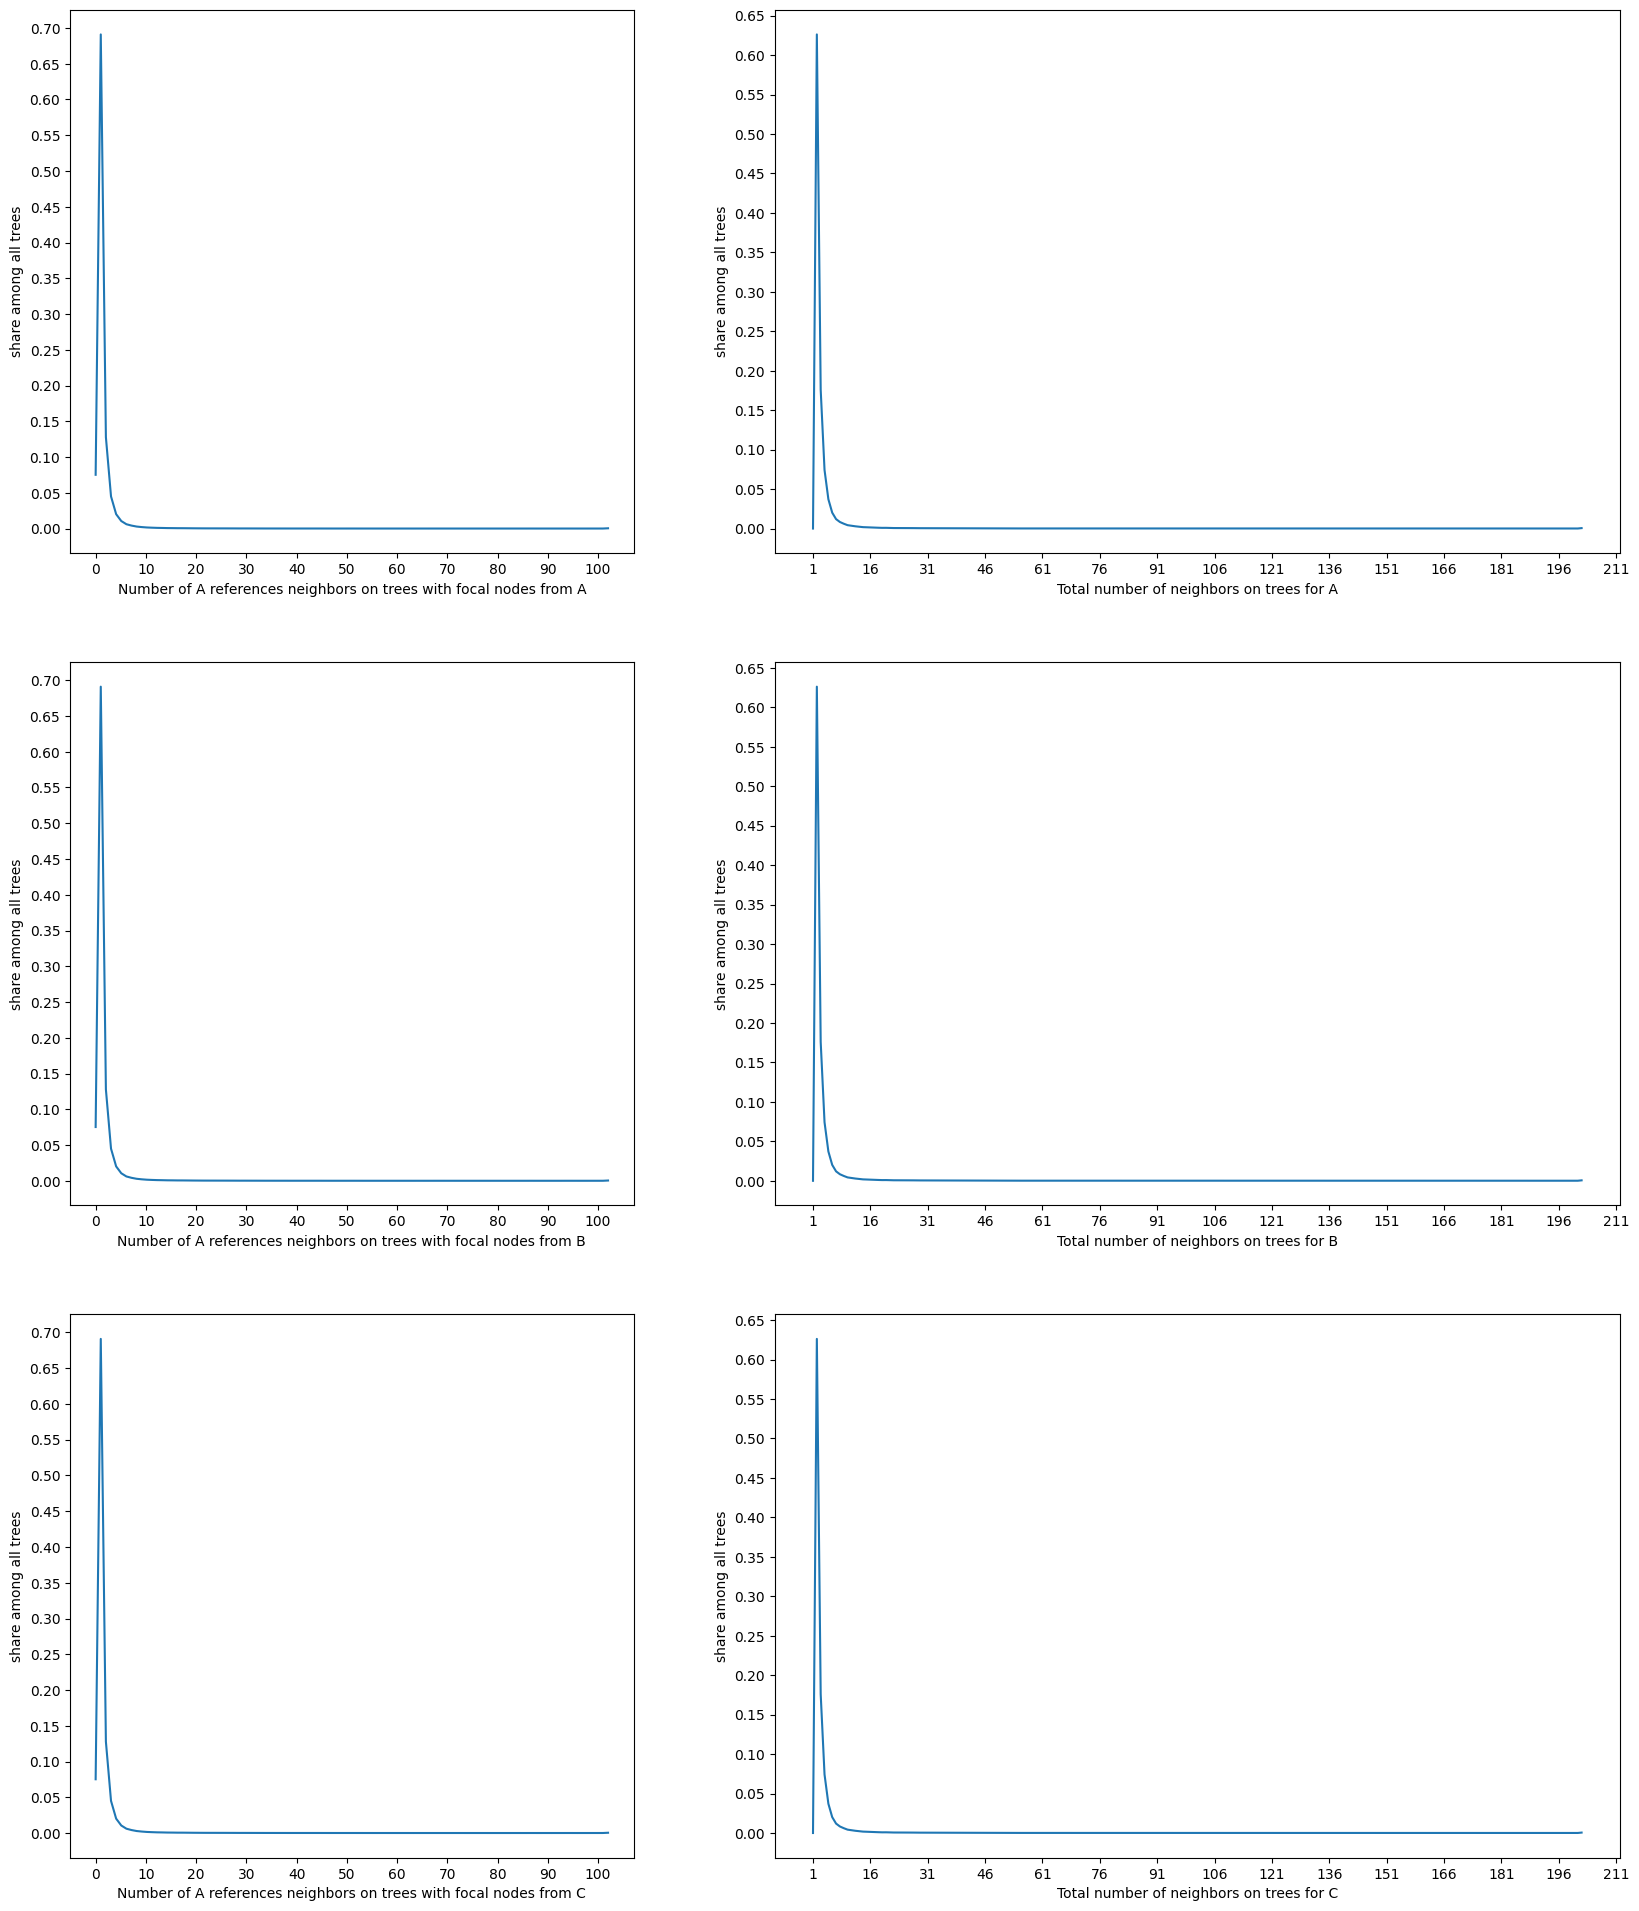

In [207]:
visualize_arg_properties(g_results[:, 1, :, :], h_results[:, 1, :, :], ver, status="inf")

### Усредняем по большому количеству экспериментов

Прогоним симуляции по repl репликейтов, чтобы выяснить смещение оценки и бутстрепировать доверительный интервал

In [233]:
def universe_worker(uni_id):
    alpha_results = np.zeros((2, 3, vecsize), dtype=np.float64)
    g_results = np.zeros((2, 3, vecsize), dtype=np.float64)
    h_results = np.zeros((2, 3, long_vecsize), dtype=np.float64)
    arg_stats_results = np.zeros((2, 7), dtype=np.float64)
    
    # for ai, alpha in enumerate(alphas):
    inpt = [(alphas[0], ai, uni) for ai in range(replicates)]
    with concurrent.futures.ProcessPoolExecutor(max_workers=os.cpu_count()) as executor: # min(os.cpu_count(), replicates)
        many_tuples = list(executor.map(worker, inpt))
        alpha_results = np.mean(np.array([tup[0] for tup in many_tuples]), axis=0)
        g_results = np.mean(np.array([tup[1] for tup in many_tuples]), axis=0)
        h_results = np.mean(np.array([tup[2] for tup in many_tuples]), axis=0)
        arg_stats_results = np.mean(np.array([tup[3] for tup in many_tuples]), axis=0)

    save_name = f"middle_numpy/u{uni_id}_v{ver}"
    np.save(f"{save_name}_alpha_res.npy", alpha_results)
    np.save(f"{save_name}_g_res.npy", g_results)
    np.save(f"{save_name}_h_res.npy", h_results)
    np.save(f"{save_name}_arg_stats.npy", arg_stats_results)
    
    estimation_results = np.zeros(2, dtype=np.float64)
    fnA = alpha_results[0][0]
    fnB = alpha_results[0][1]
    fnC = alpha_results[0][2]
    fiA = alpha_results[1][0]
    fiB = alpha_results[1][1]
    fiC = alpha_results[1][2]
    # estimation_results[0] = alpha
    estimation_results[0] = minimize(target_func, x0=start_guess, args=(fnA, fnB, fnC), method='COBYQA', bounds=bnd).x[0]
    estimation_results[1] = minimize(target_func, x0=start_guess, args=(fiA, fiB, fiC), method='COBYQA', bounds=bnd).x[0]
    # если понадобятся доп данные, мы их сможем достать из сохраненных массивов. Так что пока возвращаем целевую переменную
    return estimation_results 

Чтобы напараллелить себе 100 результатов этой функцией, вне этого ноутбука запускал этот код как скрипт (task.py). У нас теперь есть массив со 100 х 2 значениями: на истинном графе и на восстановленном

In [3]:
all_results = np.load("all_results.npy")
all_alphas_hat = all_results[:, 0]
all_alphas_hat_hat = all_results[:, 1]

In [4]:
true_alpha = 0.5

In [6]:
print(f"mean: {np.mean(all_alphas_hat) :.4f} \\ {np.mean(all_alphas_hat_hat) :.4f}")

mean: 0.4104 \ 0.4495


### Смещение со знанием истинного значения

In [16]:
true_arg_shift = np.mean(all_alphas_hat) - true_alpha
inf_arg_shift = np.mean(all_alphas_hat_hat) - true_alpha

In [17]:
print(f"Bias: {true_arg_shift :.4f} \\ {inf_arg_shift :.4f}")

Bias: -0.0896 \ -0.0505


### Доверительный 95%-й интервал с бутстрепом

Обозначая $\alpha$-й перцентиль: $\theta_{\%ile} [\alpha]$, наш доверительный $95%$-й интервал это $(\theta_{\%ile} [0.025], \theta_{\%ile} [0.975])$

По всем экспериментам имеем усредненную статистику $\hat{\theta}$, на $b-$й из $B$  псевдосимуляций имеем $\hat{\theta}^{*b}$. Пропорция их, не превышающая $\hat{\theta}$, есть значение

$\displaystyle p_0 = \frac{\# \{\hat{\theta}^{*b} \le \hat{\theta} \} }{B}$

Значение обратной CDF стандартного нормального распределения обозначаем $z^{(\alpha)} := F^{(-1)} (\alpha)$, оно же - квантиль. Коррекция смещения (bias-correction value):

$z_0 = F^{-1} (p_0)$

И тогда границами интервала будут перцентили массива бутстрепа

$\theta_{\%ile} [ F(2 z_0 + z^{(\alpha)}) ]$

Но так как смещение мы знаем, то восстановить более близкое к правильному значение мы можем, получив

$(\theta_{L} - Bias, \theta_{U} - Bias)$

(Computer Age Statistical Inference - Bradley Efron)

In [18]:
# количество псевдовыборок
B = 100000

In [19]:
def bc_ci(arr, bias, b):
    percent = 100
    a_low = 0.025
    a_high = 0.975
    
    bootstrap_alpha = np.array([arr[np.random.randint(100)] for i in range(b)])
    p0 = bootstrap_alpha[bootstrap_alpha <= np.mean(arr)].size / b
    z0 = norm.ppf(p0)
    lo = np.percentile(bootstrap_alpha, norm.cdf(2*z0 + norm.ppf(a_low)) * percent)
    up = np.percentile(bootstrap_alpha, norm.cdf(2*z0 + norm.ppf(a_high)) * percent)
    print(f"interval: ({lo - bias :.4f}; {up - bias :.4f})" )

In [20]:
bc_ci(all_alphas_hat, true_arg_shift, B)

interval: (0.4653; 0.5288)


In [21]:
bc_ci(all_alphas_hat_hat, inf_arg_shift, B)

interval: (0.4673; 0.5266)
